In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix


from wordcloud import WordCloud
import re
import nltk

#Uncomment below snippets if not available in test bench
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.corpus import stopwords

import gensim
import gensim.downloader as gensim_api

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option.max_rows = None

# EDA

In [2]:
cat_df = pd.read_csv("categories.csv")
cat_df

,id,category
0,1,Layoff
1,2,Mergers and Acquisitions
2,3,Mass Hiring
3,4,Executive Movement
4,5,Centre Setup and Expansion
5,6,Deals
6,7,Partnerships


In [3]:
map_df = pd.read_excel("category_mapping.xlsx",sheet_name="Sheet1")
print(map_df.head())
map_df.duplicated().value_counts()

                           news_id  category_id
0  5cb377684f646938b14a96f1_google            4
1  5cb426d44f646938b10bf6b6_google            4
2  5cb429984f646938b110f937_google            2
3  5cb426b34f646938b10bbeca_google            5
4  5cb426f74f646938b10c3857_google            7


False    2636
True      908
dtype: int64

> There are 908 duplicate records/rows in the category mapping dataframe which needs to be removed.

In [4]:
#There were some duplicates identified in map_df. hence removing them via drop_duplicates command
map_df = map_df.drop_duplicates()
print("total number of unique articles: ",map_df.news_id.nunique())
print("total articles: ",map_df.news_id.count())

total number of unique articles:  2635
total articles:  2636


> Every news article is being assigned to one class(out of 7). Hence it is a multiclass classification problem

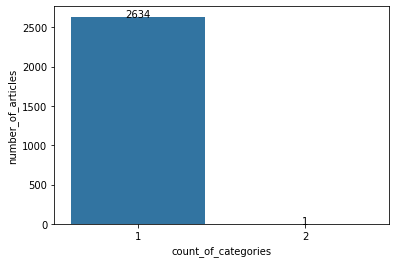

In [5]:
temp = pd.DataFrame(map_df.news_id.value_counts()).reset_index()
temp = pd.DataFrame(temp.news_id.value_counts()).reset_index()
temp.columns = ['count_of_categories','number_of_articles']
bar = sns.barplot(temp['count_of_categories'],temp['number_of_articles'])
for index, row in temp.iterrows():
    bar.text(row.name,row.number_of_articles, round(row.number_of_articles,2), color='black', ha="center")

> All the articles in the news_details dataset has an entry in the category_mapping dataset.

In [6]:
news_df = pd.read_excel("news_details.xlsx",sheet_name = 'Sheet1')
print(news_df.duplicated().value_counts())
news_df.head()

False    2720
True      824
dtype: int64


,news_id,snippet,title,news_description
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN


> There are 824 duplicate records in the news_df dataframe which needs to be removed

In [7]:
news_df = news_df.drop_duplicates()
print("Total Number of articles in the news_details data: " , news_df.news_id.nunique())

#Checking whether there is a mapping for every article in the category mapping table. 
pd.Series(news_df.news_id.unique()).isin(map_df.news_id.unique()).value_counts()

Total Number of articles in the news_details data:  2635


True    2635
dtype: int64

> There is a mapping for every news article, hence we do not need much processing for target class

In [8]:
#Combining news data with the associated categories and creating the training dataset
cat_map_df = cat_df.merge(map_df,left_on='id',right_on='category_id')[['news_id','category']]
# cat_map_df = pd.crosstab(cat_map_df['news_id'],cat_map_df['category']).reset_index(level='news_id')
cat_map_df

,news_id,category
0,5cb516014f646938b1bda75b_google,Layoff
1,5cb42d064f646938b1178e03_google,Layoff
2,5cb419f44f646938b1f851de_google,Layoff
3,5cb6bbcc4f646938b10fe4b8_google,Layoff
4,5cb6c3234f646938b1199b88_google,Layoff
...,...,...
2631,5cd5468c29458140edccef58_google,Partnerships
2632,5cd5abab29458140edab30e8_google,Partnerships
2633,5cd54df629458140edd686f1_google,Partnerships
2634,5cd3cb1d29458140edbab1e6_google,Partnerships


> Using crosstab to pivot the data in such a way that every record corresponds to news_id with respect to all the categories

In [9]:
df = news_df.merge(cat_map_df,on='news_id')
df['text'] = (df['snippet']+" "+ df['title']+" "+df['news_description'].fillna("")).astype(str)
print("the dimensions of the new dataframe are:" ,df.shape)
df.head()

the dimensions of the new dataframe are: (2721, 6)


,news_id,snippet,title,news_description,category,text
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN,Executive Movement,"New Delhi: Bank of Baroda, which has become th..."
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...,Executive Movement,He said his plans would be discussed with the ...
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...,Mergers and Acquisitions,ZF Friedrichshafen AG has announced that it ha...
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...,Centre Setup and Expansion,Zhejiang Geely Holding (ZGH) has begun constru...
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN,Partnerships,KFH has partnered with IDEMIA to launch Kuwait...


In [10]:
replace_special_char = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords_re = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower() # lowercase text
    text = replace_special_char.sub(' ', text)
    text = bad_symbols.sub('', text)
    text = text.split()
    text = [word for word in text if word not in stopwords_re]
    
#     Stemming and Lemmatization are not being here as they were resulting into decrease in accuracy of logistic and xgboost model    
#     ps = nltk.stem.porter.PorterStemmer()
#     text = [ps.stem(word) for word in text]
#     lem = nltk.stem.wordnet.WordNetLemmatizer()
#     text = [lem.lemmatize(word) for word in text]
    text = " ".join(text)
    return text
    
df['text'] = df['text'].apply(clean_text)

> The shape of df and news_df indicate that all rows have been properly mapped to the category pivots

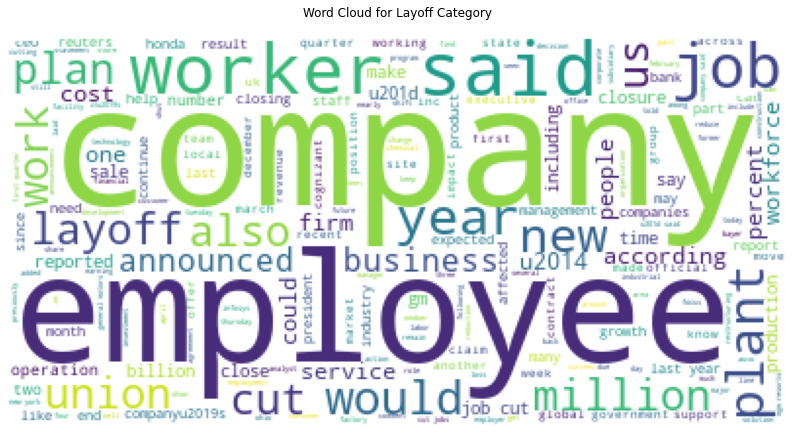

In [11]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Layoff', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Layoff Category\n")
plt.show()

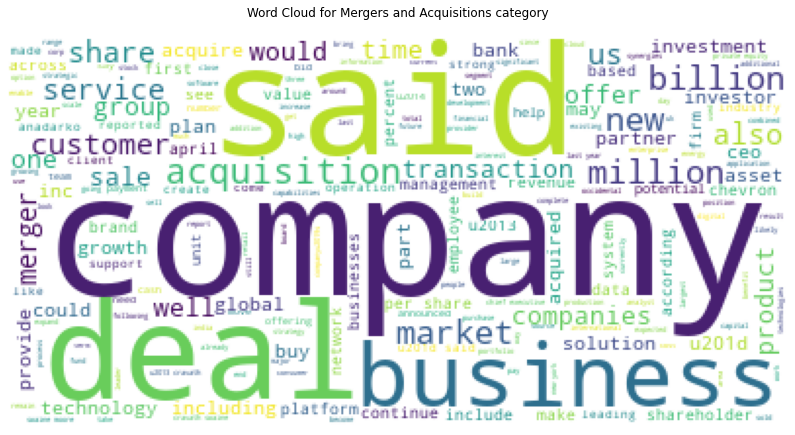

In [12]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Mergers and Acquisitions', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Mergers and Acquisitions category\n")
plt.show()

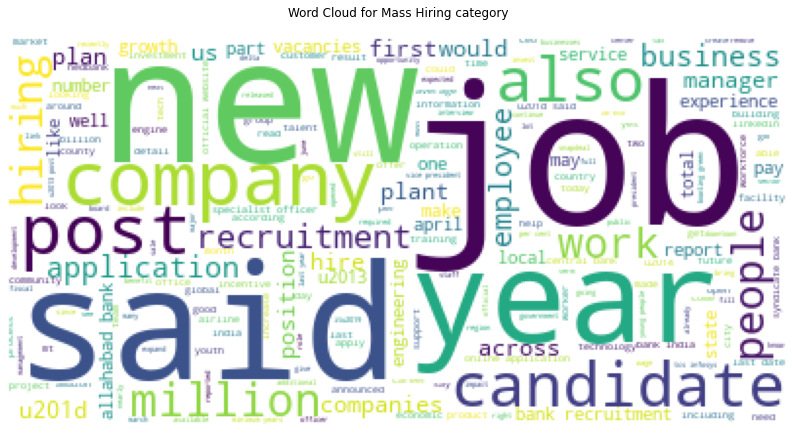

In [13]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Mass Hiring', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Mass Hiring category\n")
plt.show()

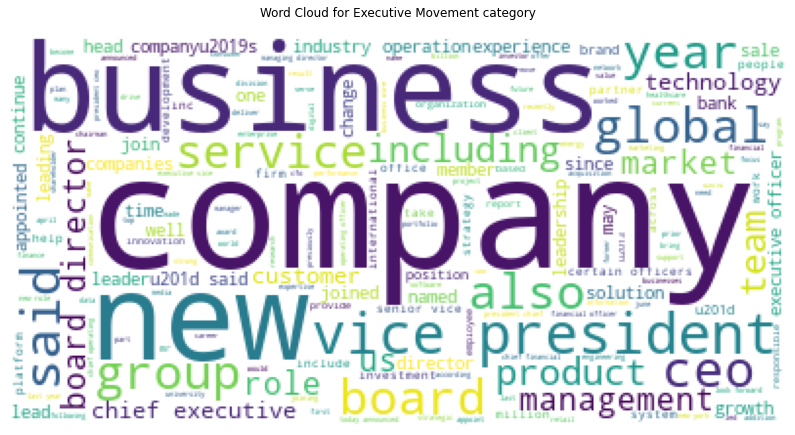

In [14]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Executive Movement', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Executive Movement category\n")
plt.show()

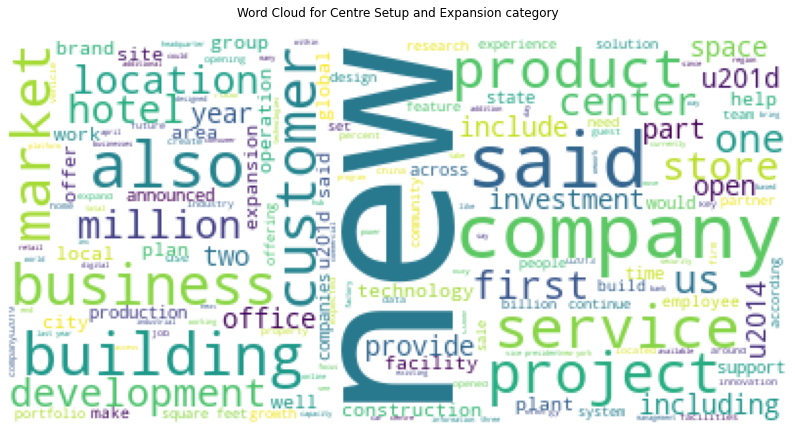

In [15]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Centre Setup and Expansion', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Centre Setup and Expansion category\n")
plt.show()

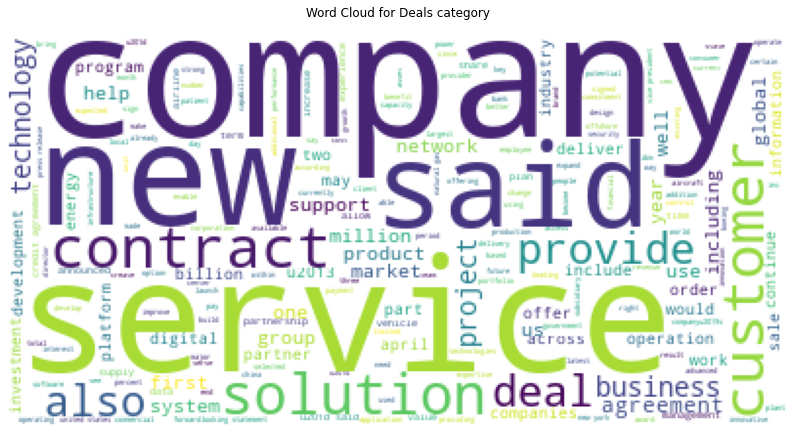

In [16]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Deals', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Deals category\n")
plt.show()

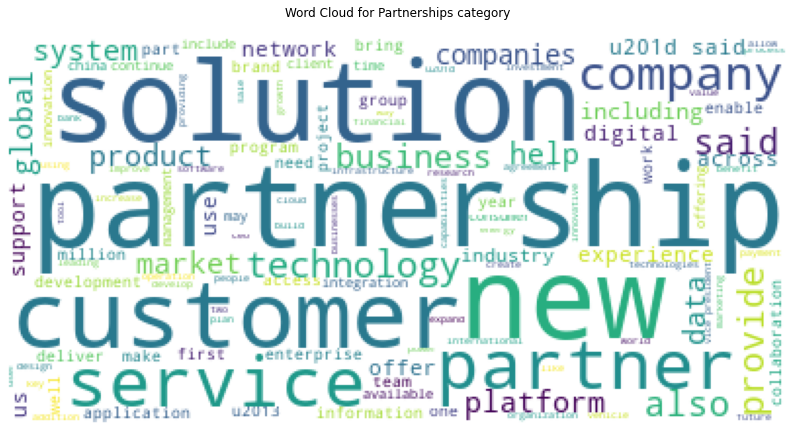

In [17]:
cloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords.words('english'))

wcloud = cloud.generate(df.loc[df.category == 'Partnerships', 'text'].str.cat(sep='\n'))
plt.figure(figsize=(14,9))
plt.imshow(wcloud)
plt.axis("off")
plt.title("Word Cloud for Partnerships category\n")
plt.show()

### Check Class Distribution

,category,number_of_articles
0,Centre Setup and Expansion,462
1,Deals,355
2,Executive Movement,676
3,Layoff,84
4,Mass Hiring,82
5,Mergers and Acquisitions,377
6,Partnerships,600


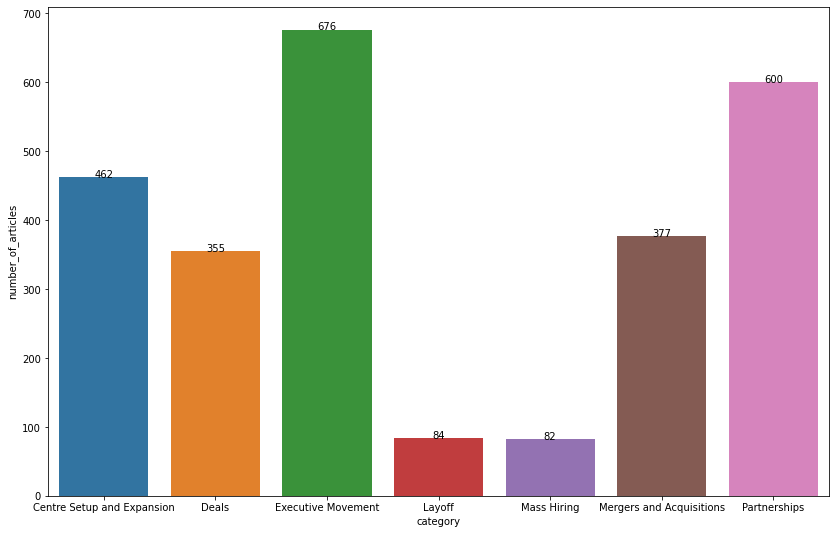

In [18]:
temp = df.groupby('category').nunique()['news_id'].reset_index()
temp.columns = ['category','number_of_articles']
plt.figure(figsize=(14,9))
bar = sns.barplot(temp['category'],temp['number_of_articles'])
for index, row in temp.iterrows():
    bar.text(row.name,row.number_of_articles, round(row.number_of_articles,2), color='black', ha="center")

temp

## Training

In [19]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.category.values)


X_train, X_test, y_train, y_test = train_test_split(df.text.values.astype('U'), y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

> Encoding the target categories in above cell

In [20]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xtest_tfv = tfv.transform(X_test)

> Converting the word vectors to tf-idf vectors in above cell

### Fitting a logistic regression on TF-IDF features

In [21]:
clf_lr = LogisticRegression(C=1.0)
clf_lr.fit(xtrain_tfv, y_train)

LogisticRegression()

The accuracy of training set using a simple logistic regression built using one vs all class is:  0.9434742647058824
The accuracy of test set using a simple logistic regression built using one vs all class is:  0.8

The confusion matrix is as below



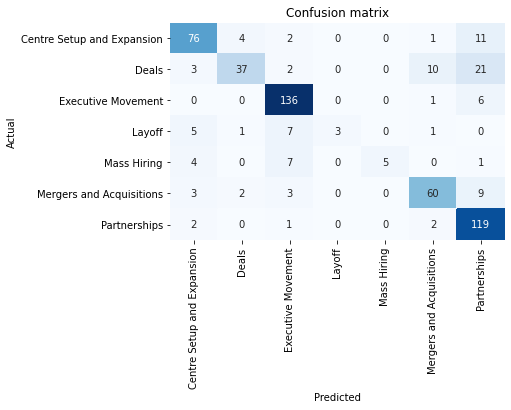

In [22]:
predictions = clf_lr.predict(xtest_tfv)
predictions_train = clf_lr.predict(xtrain_tfv)
m = confusion_matrix(y_test,predictions)

fig, ax = plt.subplots()
sns.heatmap(m, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=lbl_enc.inverse_transform(np.unique(y_test)), 
       yticklabels=lbl_enc.inverse_transform(np.unique(y_test)), title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

print("The accuracy of training set using a simple logistic regression built using one vs all class is: ", accuracy_score(y_train,predictions_train))
print("The accuracy of test set using a simple logistic regression built using one vs all class is: ", accuracy_score(y_test,predictions))
print("\nThe confusion matrix is as below\n" )

> Category wise accuracy shows that class number 0,2,5,6 are giving decent accuracy but the other classes require a improvement

In [23]:
temp = pd.DataFrame(np.unique(lbl_enc.inverse_transform(y_test), return_counts=True)).T
temp.columns = ['category','Total_news_articles']
temp['accuracy'] = m.diagonal()/m.sum(axis=1)
print("category wise accuracy score:\n")
temp

category wise accuracy score:



,category,Total_news_articles,accuracy
0,Centre Setup and Expansion,94,0.808511
1,Deals,73,0.506849
2,Executive Movement,143,0.951049
3,Layoff,17,0.176471
4,Mass Hiring,17,0.294118
5,Mergers and Acquisitions,77,0.779221
6,Partnerships,124,0.959677


> Some of the observations from the above table and confusion matrix are:

    1.Classes with low number of instances seem to have low accuracy. Class imbalance is coming to into play. Some techniques which can be tried include resampling, generate synthetic data or try a different model.
    2. From confusion matrix it can be seen that a lot of articles under Deals category are getting categorized into Patnerships. Technically both terms seem very similar and we may want to try and create some separation between these 2 classes.

### XGBoost on TF-IDF data

In [24]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=6, n_estimators=250, colsample_bytree=0.8, 
                        subsample=0.8, nthread=4, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

The accuracy of training set using a xgboost model is:  0.9986213235294118
The accuracy of test set using a xgboost model is:  0.8458715596330275

The confusion matrix is as below



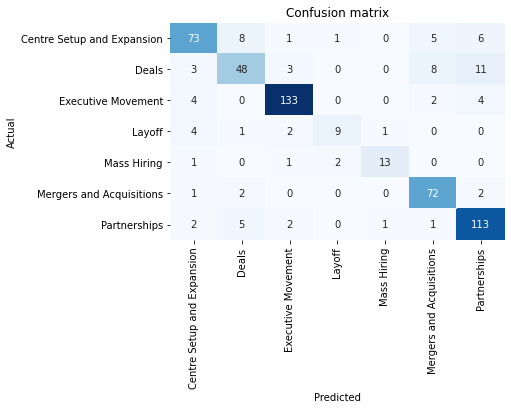

In [25]:
predictions = clf.predict(xtest_tfv.tocsc())
predictions_train = clf.predict(xtrain_tfv.tocsc())

m = confusion_matrix(y_test,predictions)

fig, ax = plt.subplots()
sns.heatmap(m, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=lbl_enc.inverse_transform(np.unique(y_test)), 
       yticklabels=lbl_enc.inverse_transform(np.unique(y_test)), title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

print("The accuracy of training set using a xgboost model is: ", accuracy_score(y_train,predictions_train))
print("The accuracy of test set using a xgboost model is: ", accuracy_score(y_test,predictions))
print("\nThe confusion matrix is as below\n" )

In [26]:
temp = pd.DataFrame(np.unique(lbl_enc.inverse_transform(y_test), return_counts=True)).T
temp.columns = ['category','Total_news_articles']
temp['accuracy'] = m.diagonal()/m.sum(axis=1)
temp

,category,Total_news_articles,accuracy
0,Centre Setup and Expansion,94,0.776596
1,Deals,73,0.657534
2,Executive Movement,143,0.930070
3,Layoff,17,0.529412
4,Mass Hiring,17,0.764706
5,Mergers and Acquisitions,77,0.935065
6,Partnerships,124,0.911290


> Overall accuracy across classes seem to have improved but average accuracy has just improved by 5%

### Using GridSearch to find best hyperparameters for xgboost
`Below sections are commented out as we are already selecting the best model derived from hyperparameter tuning using below techniques`

In [27]:
# params = {
#         'min_child_weight': [1, 5, 10],
# #         'gamma': [0, 0.5, 1, 1.5, 2],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [5, 6, 7, 8]
#         }

In [28]:
# clf_xgb_cv = xgb.XGBClassifier(max_depth=6, n_estimators=250, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=4, learning_rate=0.1)

In [29]:
# folds = 10
# param_comb = 15

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

# random_search = RandomizedSearchCV(clf_xgb_cv, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(xtrain_tfv.tocsc(), y_train), verbose=3, random_state=42 )

# random_search.fit(xtrain_tfv.tocsc(), y_train)

In [30]:
# predictions = random_search.predict(xtest_tfv.tocsc())
# predictions_train = random_search.predict(xtrain_tfv.tocsc())

# m = confusion_matrix(y_test,predictions)

# fig, ax = plt.subplots()
# sns.heatmap(m, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=lbl_enc.inverse_transform(np.unique(y_test)), 
#        yticklabels=lbl_enc.inverse_transform(np.unique(y_test)), title="Confusion matrix")
# plt.yticks(rotation=0)
# plt.xticks(rotation=90)

# print("The accuracy of training set using a xgboost model is: ", accuracy_score(y_train,predictions_train))
# print("The accuracy of test set using a xgboost model is: ", accuracy_score(y_test,predictions))
# print("\nThe confusion matrix is as below\n" )

> The gridsearch randomization is giving similar results as xgboost model. Hence the parameters selected are optimal

### Gensim based word to vec

In [31]:
nlp = gensim_api.load("word2vec-google-news-300")

In [32]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format(fname="C:/Users/mc8311/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz",binary=True)
wv.init_sims(replace=True)

In [33]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [34]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test[['text']].apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train[['text']].apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['category'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.category))
# print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.7821297429620563


> Word2vec did not result into good accracy and hence it is not used further.

### BERT

> BERT IPython notebook is shared seperately as it was run on Google Colab using Keras and hence the outputs for BERT are maintained in that notebook

## Creating an Ensemble

`We are creating an ensemble of xgboost and logistic regression for getting the final results. As seen above this model has an accuracy of approx 85% on test/validation data.`

`Bert had given an accuracy of 91% on validation data, but since the predictor function has to be sent along with the notebook, BERT model would not have resulted into a self contained notebook(considering the size and embeddings availability on test bench), hence it is kept seperate and not used in the final predictions.`

In [36]:
predictions_lr = clf_lr.predict_proba(xtest_tfv)
predictions_train_lr = clf_lr.predict_proba(xtrain_tfv)
predictions_xgb = clf.predict_proba(xtest_tfv.tocsc())
predictions_train_xgb = clf.predict_proba(xtrain_tfv.tocsc())

In [37]:
avg_predictions = (predictions_xgb+predictions_lr)/2
armax = lambda x: np.argmax(x)
predictions = np.array(list(map(armax, (avg_predictions))))

The accuracy of training set using a xgboost model is:  0.9986213235294118
The accuracy of test set using a xgboost model is:  0.8568807339449541

The confusion matrix is as below



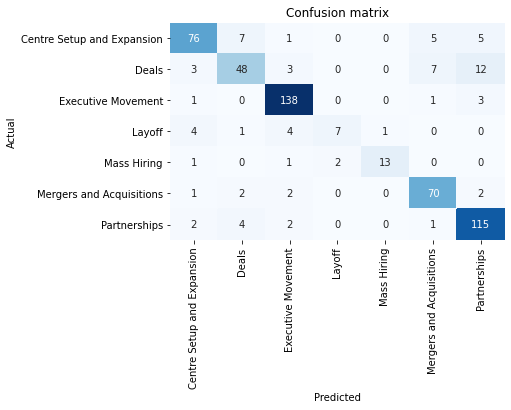

In [38]:
m = confusion_matrix(y_test,predictions)

fig, ax = plt.subplots()
sns.heatmap(m, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=lbl_enc.inverse_transform(np.unique(y_test)), 
       yticklabels=lbl_enc.inverse_transform(np.unique(y_test)), title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

print("The accuracy of training set using a xgboost model is: ", accuracy_score(y_train,predictions_train))
print("The accuracy of test set using a xgboost model is: ", accuracy_score(y_test,predictions))
print("\nThe confusion matrix is as below\n" )

## Creating the predictor function for new data

The below function will have following assimption before reunning:
   1. tfv, clf_lr, clf are available from above run cells.
   2. Since the embedding is done using tf-idf any new term which is unseen during training would be ignored.
   3. Function will accept a dataframe with similar format as provided for training.

In [39]:
def predictor(df_predict):
    df_predict['text'] = (df_predict['snippet']+" "+ df_predict['title']+" "+df_predict['news_description'].fillna("")).astype(str)
    df_predict['text'] = df_predict['text'].apply(clean_text)
    predict_tfv = tfv.transform(df_predict['text'])
    predictions_lr = clf_lr.predict_proba(predict_tfv)
    predictions_xgb = clf.predict_proba(predict_tfv.tocsc())
    avg_predictions = (predictions_xgb+predictions_lr)/2
    armax = lambda x: np.argmax(x)
    predictions = np.array(list(map(armax, (avg_predictions))))

    df_predict['Prediction'] = lbl_enc.inverse_transform(predictions)
    return df_predict

In [40]:
#Replace df_predict with new file on which predictions are to be done
df_predict = pd.read_excel("news_details.xlsx",sheet_name='Sheet1')
predictor(df_predict)

,news_id,snippet,title,news_description,text,Prediction
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN,new delhi bank baroda become countrys second l...,Executive Movement
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...,said plans would discussed board foxconn world...,Executive Movement
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...,zf friedrichshafen ag announced finalized deal...,Mergers and Acquisitions
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...,zhejiang geely holding zgh begun construction ...,Centre Setup and Expansion
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN,kfh partnered idemia launch kuwaits first meta...,Partnerships
...,...,...,...,...,...,...
3539,5cd41b4729458140ed753ffd_google,The two offices in Vienna's Guglgasse and in t...,"Nagarro Office Opening: ""Work is the place whe...",The two offices in Guglgasse and Alte AKH in V...,two offices viennas guglgasse old akh became s...,Centre Setup and Expansion
3540,5cd44e3329458140ed0bebdd_google,Airbus Americas Inc. has inked a deal for expa...,Exclusive: Airbus inks deal for more space in ...,Airbus Americas Inc. has inked a deal for expa...,airbus americas inc inked deal expansion space...,Deals
3541,5cd418f329458140ed6dfaaa_google,"Single Digits, Inc. announced today that it ha...",Single Digits Acquires The High-Speed Internet...,"Single Digits, Inc. announced today that it ha...",single digits inc announced today completed ac...,Mergers and Acquisitions
3542,5cd4116529458140ed561679_google,"Tempus Resources Ltd (ASX: TMR), a mineral exp...",Tempus Resources Acquired 2 Ecuadorian compani...,"Tempus Resources Ltd (ASX: TMR), a mineral exp...",tempus resources ltd asx tmr mineral explorati...,Executive Movement
